# Check for GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-664ec476-2f5b-94f5-9fe7-752bf6e54938)


# Initial Imports

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa

print(f'Tensorflow v{tf.__version__}, using {tf.test.gpu_device_name()}')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Tensorflow v2.4.1, using /device:GPU:0
/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


# BERT Model and Tokenizer

In [3]:
bert_type = 'bert-base-cased'

In [4]:
from transformers import TFBertModel, BertTokenizerFast

bert = TFBertModel.from_pretrained(bert_type)
tokenizer = BertTokenizerFast.from_pretrained(bert_type)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


## Text Cleaning

In [5]:
import re
import string

def remove_html_tag(text):
  cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
  text = re.sub(cleanr, '', text)
  return text

## Load Dataset and Clean Text

In [6]:
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df['clean_text'] = df.review.apply(lambda text: remove_html_tag(text))
df

,review,sentiment,clean_text
0,One of the other reviewers has mentioned that ...,positive,One of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,A wonderful little production. The filming tec...
2,I thought this was a wonderful way to spend ti...,positive,I thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,Basically there's a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"Petter Mattei's ""Love in the Time of Money"" is..."
...,...,...,...
49995,I thought this movie did a down right good job...,positive,I thought this movie did a down right good job...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,"Bad plot, bad dialogue, bad acting, idiotic di..."
49997,I am a Catholic taught in parochial elementary...,negative,I am a Catholic taught in parochial elementary...
49998,I'm going to have to disagree with the previou...,negative,I'm going to have to disagree with the previou...


## Token Length Exploration

In [7]:
df.clean_text.apply(lambda x: len(x.split(' '))).describe()

count    50000.00000
mean       227.10428
std        168.26324
min          4.00000
25%        124.00000
50%        170.00000
75%        275.00000
max       2450.00000
Name: clean_text, dtype: float64

## Data Preparation

In [8]:
from sklearn.model_selection import train_test_split

x = df.clean_text
y = pd.get_dummies(df.sentiment).values
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                  test_size=0.2, random_state=42)

x_train = tokenizer.batch_encode_plus(x_train.to_list(),
                                      return_tensors='tf',
                                      max_length=256,
                                      padding='max_length',
                                      truncation=True).values()
x_test = tokenizer.batch_encode_plus(x_test.to_list(),
                                     return_tensors='tf',
                                     max_length=256,
                                     padding='max_length',
                                     truncation=True).values()
x_val = tokenizer.batch_encode_plus(x_val.to_list(),
                                    return_tensors='tf',
                                    max_length=256,
                                    padding='max_length',
                                    truncation=True).values()

# Model

## Create BERT Classifier Model

In [9]:
# Input
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
token_type_ids = tf.keras.layers.Input(shape=(256,), name='token_type_ids', dtype='int32')
attention_mask = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')
inputs = [input_ids, token_type_ids, attention_mask]
# Output
outputs = bert(inputs)[1]
outputs = tf.keras.layers.Dropout(0.1, name='dropout')(outputs)
outputs = tf.keras.layers.Dense(2, activation='softmax', name='classifier')(outputs)
# Generate Model
model = tf.keras.Model(inputs=inputs, outputs=outputs, name='bert_classifier')
model.summary()

Model: "bert_classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 token_type_ids[0][0

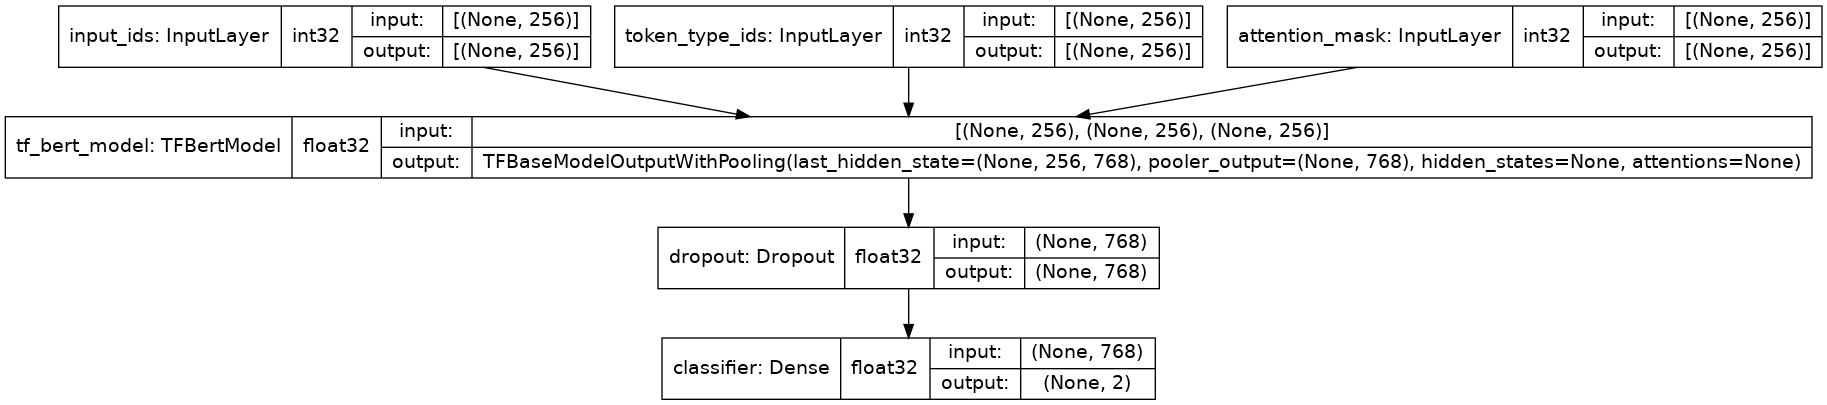

In [10]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

## Hyperparameter

In [11]:
lr = 2e-5
epochs = 5
batch_size = 32

## Model Compilation (Optimizer, Loss Function, Metrics)

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr), 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.CategoricalAccuracy(), 
                       tfa.metrics.F1Score(2)])

## Model Training

In [13]:
history = model.fit(x_train, 
                    y_train, 
                    validation_data=(x_val, y_val), 
                    epochs=epochs, 
                    batch_size=batch_size)

Epoch 1/5
1000/1000 [==============================] - 992s 983ms/step - loss: 0.3802 - categorical_accuracy: 0.8117 - f1_score: 0.8112 - val_loss: 0.2138 - val_categorical_accuracy: 0.9147 - val_f1_score: 0.9147
Epoch 2/5
1000/1000 [==============================] - 983s 983ms/step - loss: 0.1513 - categorical_accuracy: 0.9432 - f1_score: 0.9432 - val_loss: 0.2512 - val_categorical_accuracy: 0.9075 - val_f1_score: 0.9071
Epoch 3/5
1000/1000 [==============================] - 984s 984ms/step - loss: 0.0808 - categorical_accuracy: 0.9719 - f1_score: 0.9719 - val_loss: 0.2863 - val_categorical_accuracy: 0.9179 - val_f1_score: 0.9179
Epoch 4/5
1000/1000 [==============================] - 984s 985ms/step - loss: 0.0453 - categorical_accuracy: 0.9847 - f1_score: 0.9847 - val_loss: 0.3304 - val_categorical_accuracy: 0.9164 - val_f1_score: 0.9163
Epoch 5/5
1000/1000 [==============================] - 985s 985ms/step - loss: 0.0281 - categorical_accuracy: 0.9903 - f1_score: 0.9903 - val_loss: 

## Model Evaluation

In [14]:
result = model.evaluate(x_test, y_test)

313/313 [==============================] - 100s 311ms/step - loss: 0.3410 - categorical_accuracy: 0.9235 - f1_score: 0.9235


## Training Result Visualization

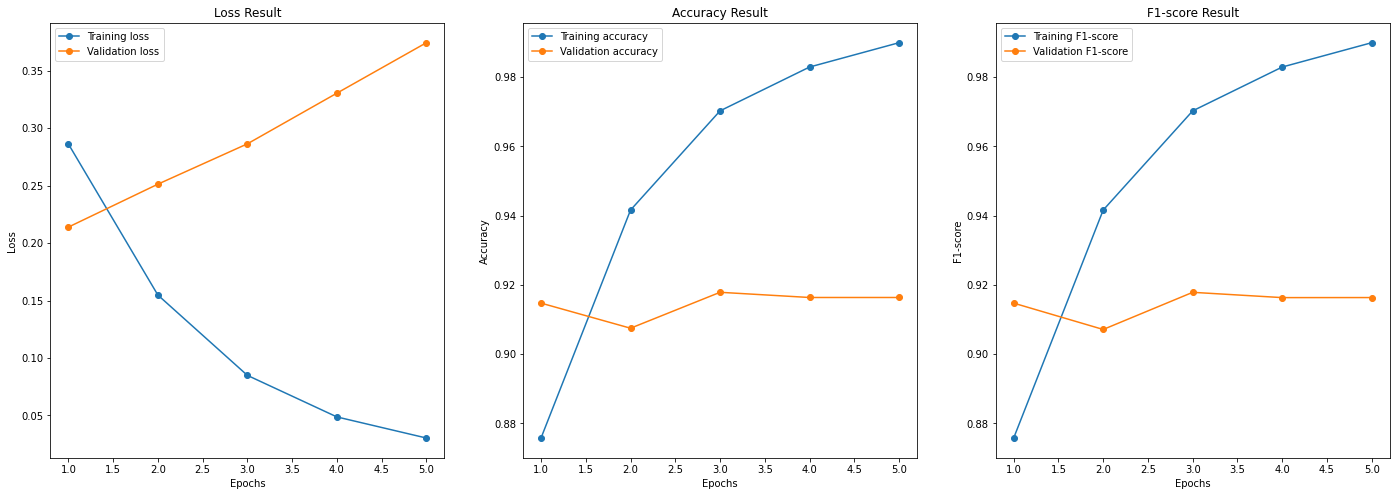

In [15]:
import matplotlib.pyplot as plt

history = history.history
epoch_range = np.arange(1, epochs+1)
# Initialize subplots
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))
# Plot loss
ax1.set_title('Loss Result')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.plot(epoch_range, history['loss'], '-o', label='Training loss')
ax1.plot(epoch_range, history['val_loss'], '-o', label='Validation loss')
ax1.legend()
# Plot accuracy
ax2.set_title('Accuracy Result')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.plot(epoch_range, history['categorical_accuracy'], '-o', label='Training accuracy')
ax2.plot(epoch_range, history['val_categorical_accuracy'], '-o', label='Validation accuracy')
ax2.legend()
# Plot F1-score
ax3.set_title('F1-score Result')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('F1-score')
ax3.plot(epoch_range, np.mean(history['f1_score'], axis=1), '-o', label='Training F1-score')
ax3.plot(epoch_range, np.mean(history['val_f1_score'], axis=1), '-o', label='Validation F1-score')
ax3.legend()
# Show plot
fig.show()